## DEEP LEARNING : FRUITS_RECOGNITION WITH VGG16 OPTIMIZED

On previous kernels, we have developed a custom convolutional neural network to classify images, and also have tried to predict using transfer learning. We have tested several pre-trained models and realized that the best performance is for VGG16. In this kernel, we are going to perform hyperparameter tuning in VGG16 model to optimize the accuracy of the model and compare this final accuracy with the one obtained with our custom model.

In [1]:
#For printing out the info of the possible devices

import tensorflow as tf
#gpus = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

tf.version.VERSION
print("Num GPUs Available: ", tf.config.list_physical_devices())

#To allow several outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


### LOADING DATA IN BATCHES

In [3]:
#We will use batches to load the data, as it is too large with the Keras option- ImageDataGenerator:

images_dir_train = r'D:\fruits-360\Training'
images_dir_test = r'D:\fruits-360\Test'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=32
epochs=20
train_datagen = ImageDataGenerator(rescale=1. / 255) 
                                    #zoom_range=0.2,
                                    #rotation_range = 5,
                                    #horizontal_flip=True)
test_datagen=   ImageDataGenerator(rescale=1. / 255, validation_split=0.5)

train_generator = train_datagen.flow_from_directory(  
                  images_dir_train,
                  target_size=(100, 100),
                  batch_size=batch_size,
                  class_mode='categorical')

val_generator =  test_datagen.flow_from_directory(  
                 images_dir_test,
                 target_size=(100, 100),
                 batch_size=batch_size,
                 class_mode='categorical',
                 subset='training')

test_generator = test_datagen.flow_from_directory(  
                 images_dir_test,
                 target_size=(100, 100),
                 batch_size=batch_size,
                 class_mode='categorical',
                 subset='validation',
                 shuffle=False)       #Not shuffling test set makes easier to test the predictions as the filenames are saved
                                      #in alphabetical order

Found 41322 images belonging to 81 classes.
Found 6942 images belonging to 81 classes.
Found 6935 images belonging to 81 classes.


### LOAD PACKAGES

In [12]:
#We will try the different algorithms and compare them with our previous defined algorithm.

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.vgg16 import VGG16

### DEACTIVATE PRE-TRAINED MODEL FULLY CONNECTED LAYERS 

We want to train only the fully connected layers, so we deactivate previous layers in the pre-trained model. 

In [13]:
#Deactivate layers

def deactivate_fully(model):
    for layer in model.layers:
        layer.trainable=False
    print('Deactivated layers in model: ' + model.name )

In [15]:
#changing the default dir for saving the history
import os
os.getcwd()

os.chdir(r'D:\fruits-360\trained_weights')
os.getcwd()

'D:\\fruits-360\\trained_weights'

### HYPERPARAMETER TUNING

We are going to define a custom function to perform hyperparameter tuning. This function builds and hypermodel. An hypermodel is the same concept as a standard model (a convolutional neural network) with the difference that besides choosing the parameters of model (number of layers....) we can also choose between a value range for hyperparameters (number of layer nodes, learning rate....). For doing that we will use 'Kerastuner' library that allows to define a search range for the hyperparameters. 

From kerastuner we will import RandomSearch and Hyperband (it is the same concepts as GridSearch for Scikit-Learn).

In [16]:
#Let´s define the custom function for define a model with hyperparameters optimization

import kerastuner as kt
from kerastuner import RandomSearch, Hyperband

new_input=Input(shape=(100,100,3))

def model_hyperparam(hp):
    
    """
    Inputs:(hp: kt.HyperParameters instance for defining a search range for several hyperparameters)
    Output: Hypermodel
    """
    
    prev_model = VGG16(weights='imagenet',include_top=False, input_tensor=new_input)
    for layer in prev_model.layers:
        layer.trainable=False

    model = Sequential()
    model.add(prev_model)
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('units',min_value=512, max_value=1536, step=128), activation='relu'))
    
    model.add(Dropout(rate=hp.Choice('rate',values=(0.3,0.4,0.5))))
    model.add(Dense(81, activation='softmax', name='predictions'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate',values=(1e-2, 1e-3, 1e-4, 1e-5))), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model
    

In [17]:
#Function to search the best hyperparameters (it is called Hyperband)

tuner=Hyperband(model_hyperparam,                            # Our custom function
                objective='val_accuracy',                    # Metric to optimize.
                max_epochs=10,                               # Maximum epoch number for each combination (each model).
                factor=3,                                    # Number of models to consider in next iteration of Hyperband
                directory=r'D:\fruits-360\trained_weights',  # Directory path for saving results of experiments.
                project_name='keras_tuner_fruits',
                overwrite=True)

In [18]:
# Defining a callback to stop the process if the results are not improving after 5 iterations.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
# We need to jump to next batch 

train_data,train_label = train_generator.next()
val_data,val_label = val_generator.next()

In [20]:
#Starting the search process

tuner.search(train_data,train_label, epochs=10, validation_data=(val_data,val_label), callbacks=[stop_early], verbose=0, batch_size = 32)



INFO:tensorflow:Oracle triggered exit


### BEST MODEL

After performing hyperparameters tuning we can access to the best hyperparameters values. All the models calculated during the tuner iteration are saved in a dictionary inside the 'tuner' object, and we can access it. Models are saved by 'val_accuracy' order, so the first model will be the best one for our purposes.

In [21]:
#The best hyperparameters are: '1' is Dict with the best values: models are ordered by val_accuracy

best_hyperparameters = tuner.get_best_hyperparameters(1)[0] 
print('The best learning rate is: {}'.format(best_hyperparameters.get('learning_rate')))
print('The best number of units for first fully connected layer is: {}'.format(best_hyperparameters.get('units')))
print('The best dropout rate is: {}'.format(best_hyperparameters.get('rate')))

The best learning rate is: 0.001
The best number of units for first fully connected layer is: 1408
The best dropout rate is: 0.5


In [22]:
#Best hyperparameters

tuner.get_best_hyperparameters(1)[0].values

{'units': 1408,
 'rate': 0.5,
 'learning_rate': 0.001,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': 'e20dd758413cb233b1b6e5c3d5a817c3'}

In [23]:
#Best model

best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1408)              6489472   
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
predictions (Dense)          (None, 81)                114129    
Total params: 21,318,289
Trainable params: 6,603,601
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
#Compiling the best model

from tensorflow.keras.optimizers import Adam

best_model.compile(optimizer=Adam(learning_rate=best_hyperparameters.get('learning_rate')),
                    loss='categorical_crossentropy',
                    metrics = ['accuracy'])

In [26]:
#Saving the best model
model_weights=r'D:\fruits-360\trained_weights\fruits_vgg16_best_model.h5'
best_model.save(model_weights,overwrite=True,include_optimizer=True)

### TRAINING THE BEST MODEL ON THE FULL DATASET

In [16]:
#Defining checkpoints to save work as training

from tensorflow.keras.callbacks import Callback, ModelCheckpoint

filepath=r'D:\fruits-360\trained_weights\epochs_vgg16_tuned_best_epoch\training_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5'

checkpoint=ModelCheckpoint(filepath=filepath,
                           save_weights_only=False,
                           monitor='val_accuracy',
                           mode='max',
                           save_freq='epoch',
                           verbose=1,
                           save_best_only=False)

In [4]:
#Training the model and calculating the best number of epochs

import tensorflow as tf
from tensorflow.keras import models

epochs=20
model=tf.keras.models.load_model(r'D:\fruits-360\trained_weights\fruits_vgg16_best_model.h5')
history=model.fit(train_generator,
                  steps_per_epoch=train_generator.samples//batch_size, 
                  validation_data=val_generator, 
                  validation_steps=val_generator.samples//batch_size, 
                  epochs=epochs,
                  verbose=1,
                  shuffle=True,
                  callbacks=[checkpoint])

Epoch 1/20
1291/1291 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.8699
Epoch 00001: saving model to D:\fruits-360\trained_weights\epochs_vgg16_tuned\training_weights-01-0.928.hdf5
1291/1291 [==============================] - 106s 82ms/step - loss: 0.5214 - accuracy: 0.8699 - val_loss: 0.2104 - val_accuracy: 0.9275
Epoch 2/20
1291/1291 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9751
Epoch 00002: saving model to D:\fruits-360\trained_weights\epochs_vgg16_tuned\training_weights-02-0.938.hdf5
1291/1291 [==============================] - 106s 82ms/step - loss: 0.0797 - accuracy: 0.9751 - val_loss: 0.2019 - val_accuracy: 0.9376
Epoch 3/20
1291/1291 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9749
Epoch 00003: saving model to D:\fruits-360\trained_weights\epochs_vgg16_tuned\training_weights-03-0.954.hdf5
1291/1291 [==============================] - 106s 82ms/step - loss: 0.0726 - accuracy: 0.9749 - val_loss: 0

In [4]:
#Saving history of training

import pandas as pd
hist_df = pd.DataFrame(history.history) 

#save hist_df to csv: 
hist_csv_file = 'history_vgg16_hypertuned.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


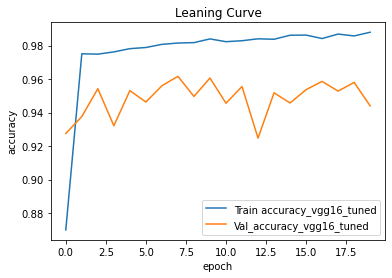

In [5]:
#Let´s see some graphics

import matplotlib.pyplot as plt
learning=pd.read_csv(r'D:\fruits-360\trained_weights\history_vgg16_hypertuned.csv', header=0, index_col=0)
    
plt.plot(learning['accuracy'], label='Train accuracy_vgg16_tuned')
plt.plot(learning['val_accuracy'], label='Val_accuracy_vgg16_tuned')
plt.title('Leaning Curve')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right');


In [9]:
#Best number of epochs

best_num_epochs=(learning['val_accuracy']).idxmax()
print('Best number of epochs:{}'.format(best_num_epochs+1))

Best number of epochs:8


Due that this process is very time consuming we have supposed a relative small number of epochs for the convergence of the model. In general is very usual a number between 150 and 200 epochs, nevertheless we consider only 20 epochs. Now we could choose a number of epochs for optimum results (we will consider 8 epochs as the best number).

In [19]:
#Now let´s train again the model with best hyperparameters and best number of epochs

epochs=8
model=tf.keras.models.load_model(r'D:\fruits-360\trained_weights\fruits_vgg16_best_model.h5')
history=model.fit(train_generator,
         steps_per_epoch=train_generator.samples//batch_size, 
         validation_data=val_generator, 
         validation_steps=val_generator.samples//batch_size, 
         epochs=epochs,
         verbose=1,
         shuffle=True,
         callbacks=[checkpoint])

Epoch 1/8
1291/1291 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.8768
Epoch 00001: saving model to D:\fruits-360\trained_weights\epochs_vgg16_tuned_best_epoch\training_weights-01-0.929.hdf5
1291/1291 [==============================] - 105s 81ms/step - loss: 0.4907 - accuracy: 0.8768 - val_loss: 0.2343 - val_accuracy: 0.9285
Epoch 2/8
1291/1291 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9745
Epoch 00002: saving model to D:\fruits-360\trained_weights\epochs_vgg16_tuned_best_epoch\training_weights-02-0.936.hdf5
1291/1291 [==============================] - 105s 81ms/step - loss: 0.0795 - accuracy: 0.9745 - val_loss: 0.2003 - val_accuracy: 0.9363
Epoch 3/8
1291/1291 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9736
Epoch 00003: saving model to D:\fruits-360\trained_weights\epochs_vgg16_tuned_best_epoch\training_weights-03-0.940.hdf5
1291/1291 [==============================] - 105s 81ms/step - loss: 0.0779 - 

In [20]:
#Saving the history of final model

hist_csv_file = 'history_vgg16_final_model.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [24]:
#Saving the final model

model_weights=r'D:\fruits-360\trained_weights\fruits_8epochs_'+model.name+'_flatten.h5'
model.save(model_weights)


In [ ]:
#Running this cell will terminate the kernel and free memory resources: 
#On Windows, signal() can only be called with SIGABRT, SIGFPE, SIGILL, SIGINT, SIGSEGV, or SIGTERM

import os, signal

os.kill( os.getpid() , signal.SIGTERM)

### FINAL VALIDATION VALUES

In [23]:
#Validate the final model 

scores_train=model.evaluate(train_generator, verbose=1)
scores_validation=model.evaluate(val_generator, verbose=1)
scores_test=model.evaluate(test_generator, verbose=1)

print('Scores_train:{}'.format(scores_train))
print('Scores_val:{}'.format(scores_validation))
print('Scores_test:{}'.format(scores_test))

217/217 [==============================] - 15s 70ms/step - loss: 0.0241 - accuracy: 0.9963
Scores_train:[0.008505932986736298, 0.9947485327720642]
Scores_val:[0.11717206239700317, 0.9645635485649109]
Scores_test:[0.02410130947828293, 0.9962509274482727]


Conclusion: We can see a very good performance of our optimized model with an accuracy value in test set of 99,63%. The accuracy value for our custom neural network was 99,08% so we have improved a little bit the performance with the VGG16 optimized model. 

Ideas for further improving of the model, is to check classes that are not well classified and perform oversampling with them on the dataset and compare results.